In [49]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np

In [50]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [51]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [52]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

In [53]:

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [54]:
img_transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [55]:
mask_transform = transforms.Compose([
    transforms.Resize((128,128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),   # gives ByteTensor, keeps class IDs
    transforms.Lambda(lambda x: x.squeeze().long())  # remove channel, convert to Long
])

In [56]:
train_dataset=datasets.OxfordIIITPet(root='data/',
                                     split='trainval',
                                     target_types="segmentation",
                                     download=True,
                                     transform=img_transform,
                                     target_transform=mask_transform)

In [57]:
test_dataset=datasets.OxfordIIITPet(root='data/',
                                    split='test',
                                    target_types='segmentation',
                                    download=True,
                                    transform=img_transform,
                                    target_transform=mask_transform)

In [58]:
train_dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: data/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: Compose(
                      Resize(size=(128, 128), interpolation=nearest, max_size=None, antialias=True)
                      PILToTensor()
                      Lambda()
                  )

In [59]:
test_dataset[0][1]

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


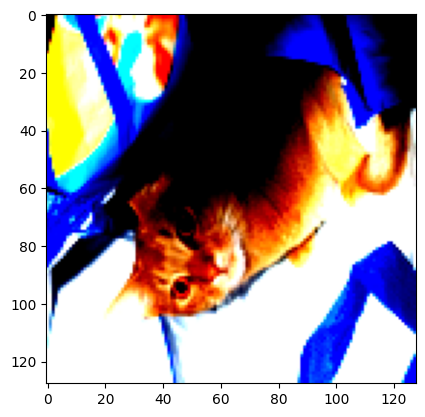

In [60]:
mask_tensor=train_dataset[0][0].squeeze()
mask_tensor=mask_tensor.permute(2,1,0)
plt.imshow(mask_tensor)

In [61]:
train_loader=DataLoader(train_dataset,32,True)
test_loader=DataLoader(test_dataset,32,True)

In [62]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [63]:
model=UNet(3,1).to(device)

In [64]:
lr=3e-4

In [65]:
optimizer=optim.AdamW(model.parameters(),lr=lr)

In [66]:
criterion = nn.CrossEntropyLoss()

In [67]:
writer=SummaryWriter(f"runs/UNET/OXFORDIIITPet")

In [68]:
#visualizing if everything is proper

dataiter = iter(train_loader)
images, masks = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
mask_grid = torchvision.utils.make_grid(masks)
writer.add_image('train/images', img_grid)
writer.add_image('train/masks', mask_grid)

TypeError: Cannot handle this data type: (1, 1, 32), |u1

In [ ]:
writer.add_graph(model, images.float().to(device))

In [ ]:
step=0

In [ ]:
for epochs in range(2):
    model.train()
    train_running_loss=0
    train_loader_tqdm=tqdm(train_loader,desc=f"Training Epoch {epochs}",leave=False)
    for idx,img_mask in enumerate(train_loader_tqdm):
        img=img_mask[0].float().to(device)
        mask=img_mask[1].float().to(device)
        y_pred=model(img)
        loss=criterion(y_pred,mask)
        train_running_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}")#when this line runs the bar is updated 
    train_loss=train_running_loss/len(train_loader)

    writer.add_scalar("Loss/train",train_loss,epochs)
    print(f"Epoch:{epochs}\nTrain Loss{train_loss}")

    model.eval()
    val_running_loss=0
    with torch.no_grad():
        test_loader_tqdm=tqdm(test_loader,desc=f"Validation Epoch {epochs}",leave=False)
        for idx,img_mask in enumerate(test_loader_tqdm):
            img=img_mask[0].float().to(device)
            mask=img_mask[1].float().to(device)
            y_pred=model(img)
            loss=criterion(y_pred,mask)
            val_running_loss+=loss.item()#you are adding the value inside loss and then later averaging
            test_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}")
            if idx%25==0:
                # y_pred: (N, C, H, W) logits from UNet
                probs = torch.softmax(y_pred, dim=1)   # per-class probabilities

                # Predicted class for each pixel
                pred_mask = torch.argmax(probs, dim=1)  # (N, H, W)

                img_grid=torchvision.utils.make_grid(img)
                mask_grid=torchvision.utils.make_grid(mask)
                pred_grid=torchvision.utils.make_grid(pred_mask)

                writer.add_image(f"Validation/Images",img_grid,global_step=step)
                writer.add_image(f"Validation/Mask",mask_grid,global_step=step)
                writer.add_image(f"Validation/Prediction",pred_grid,global_step=step)
                step+=1

        val_loss=val_running_loss/(idx+1)
        writer.add_scalar('Loss/validation',val_loss,epochs)
        print(f"Validation Loss:{val_loss}")
writer.close()

Epoch:0
Train Loss0.04233622683779053


Validation Loss:0.04246525417851365


Epoch:1
Train Loss0.04229282280025275


Validation Loss:0.04247174664683964


In [ ]:
print(mask.min().item(), mask.max().item(), mask.unique())


0.003921568859368563 0.0117647061124444 tensor([0.0039, 0.0078, 0.0118], device='cuda:0')


In [ ]:
print(mask.mean().item())


0.00697246054187417


In [ ]:
img_mask=next(iter(train_loader))
mask=img_mask[0]
print(mask.min().item(), mask.max().item())

-2.1179039478302 2.640000104904175


In [ ]:
img, mask = next(iter(train_loader))

print("Image:", img.min().item(), img.max().item())
print("Mask:", mask.min().item(), mask.max().item(), mask.unique())
#mask must be 1 or 2 or 4

Image: -2.1179039478302 2.640000104904175
Mask: 1 3 tensor([1, 2, 3])


In [ ]:
img_mask[0].min().item(),img_mask

-2.1179039478302